In [1]:
import urllib.request
import os
import zipfile
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
from shutil import copyfile
import pandas as pd

# Loading data

In [2]:
IMAGE_TEST_DIR = "/kaggle/input/sign-classification/test"
IMAGE_TRAIN_DIR = "/kaggle/input/sign-classification/final_data/final_data"
train_label_file= '/kaggle/input/sign-classification/Train.csv'
test_label_file = '/kaggle/input/sign-classification/Test.csv'

In [3]:
df_train = pd.read_csv(train_label_file)
df_test = pd.read_csv(test_label_file)

In [4]:
print("Number of training images", df_train.shape[0])
print("Number of testing images", df_test.shape[0])


Number of training images 6249
Number of testing images 2679


In [5]:
df_train.columns

Index(['img_IDS', 'Label'], dtype='object')

In [6]:
df_train["Label"].unique()

array(['Temple', 'Church', 'Enough/Satisfied', 'Me', 'Love', 'Mosque',
       'You', 'Friend', 'Seat'], dtype=object)

In [7]:
print(df_train["Label"].nunique())

9


# Process Dataset

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      brightness_range=[0.2,1.0],
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2 )

train_generator = train_datagen.flow_from_directory(IMAGE_TRAIN_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    shuffle=True)


validation_generator = train_datagen.flow_from_directory(IMAGE_TRAIN_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    subset="validation",
                                                    )




Found 6249 images belonging to 9 classes.
Found 1245 images belonging to 9 classes.


In [9]:
def preprocess_image_input(input_images):
    input_images = input_images.astype('float32')
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
    return output_ims


In [10]:

def feature_extractor(inputs):

    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224,3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)

    x = tf.keras.layers.Dense(9, activation="softmax", name="classification")(x)
    return x


def final_model(inputs):


    resnet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output


def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(224,224,3))
  
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss= tf.keras.losses.CategoricalCrossentropy() ,
              metrics=['acc'])

    return model


model = define_compile_model()

model.summary()

2023-01-11 15:18:31.241305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:31.242367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:31.378240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:31.379254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:31.380094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
______________________________________________________________

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
assert tf.test.is_gpu_available()

Num GPUs Available:  2


2023-01-11 15:18:37.775793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:37.777121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:37.778372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:37.778891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 15:18:37.779891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
EPOCHS = 15
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint] 

history = model.fit(train_generator,validation_data =validation_generator, epochs=EPOCHS, callbacks=callbacks_list)

2023-01-11 15:18:38.912071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-11 15:18:47.022152: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


196/196 [==============================] - 275s 1s/step - loss: 0.9358 - acc: 0.6822 - val_loss: 2.6858 - val_acc: 0.1108

Epoch 00001: val_loss improved from inf to 2.68578, saving model to model_weights.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
196/196 [==============================] - 226s 1s/step - loss: 0.3211 - acc: 0.8982 - val_loss: 2.0762 - val_acc: 0.2329

Epoch 00003: val_loss improved from 2.35682 to 2.07621, saving model to model_weights.h5
Epoch 4/15
196/196 [==============================] - 224s 1s/step - loss: 0.2758 - acc: 0.9102 - val_loss: 1.1458 - val_acc: 0.6016

Epoch 00004: val_loss improved from 2.07621 to 1.14579, saving model to model_weights.h5
Epoch 5/15
196/196 [==============================] - 222s 1s/step - loss: 0.2357 - acc: 0.9256 - val_loss: 0.4260 - val_acc: 0.8586

Epoch 00005: val_loss improved from 1.14579 to 0.42598, saving model to model_weights.h5
Epoch 6/15
196/196 [==============================] - 224s 1s/step - loss: 0.2212 - acc: 0.9275 - val_loss: 0.3147 - val_acc: 0.8980

Epoch 00006: val_loss improved from 0.42598 to 0.31474, saving model to model_weights.h5
Epoch 7/15
196/196 [==============================] - 223s 1s/step - loss: 0.2026 - acc: 0.9334 - val_loss: 

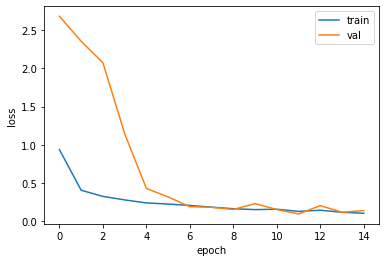

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

In [14]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_generator =  test_datagen.flow_from_directory( IMAGE_TEST_DIR,
                                                    shuffle=False,
                                                          batch_size  = 32,
                                                          class_mode  = None, 
                                                          target_size = (224, 224))

Found 2679 images belonging to 1 classes.


In [15]:
test_generator.reset()

In [16]:
model = tf.keras.models.load_model("/kaggle/working/model_weights.h5")
pred = model.predict_generator(test_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [17]:
print(pred.shape)
filenames=test_generator.filenames
print(len(filenames))

(2679, 9)
2679


In [18]:
res1 = list(map(lambda st: str.replace(st, "test/", ""), filenames))
res2 = list(map(lambda st: str.replace(st, ".jpg", ""), res1))


In [19]:
actual = train_generator.classes

In [20]:
import os
submission = pd.DataFrame()
submission["ID"] = res2
classes = ["Church","Enough/Satisfied","Friend","Love","Me","Mosque","Seat","Temple","You"]
for i, c in enumerate(classes):
    print(c)
    print(i)
    submission[c] = pred[:,i]
submission.head()

Church
0
Enough/Satisfied
1
Friend
2
Love
3
Me
4
Mosque
5
Seat
6
Temple
7
You
8


,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_00AVE728,0.000019,7.786445e-08,6.891911e-08,1.409416e-07,1.575003e-08,1.466804e-07,1.319656e-08,9.999802e-01,2.575879e-08
1,ImageID_00CB7YJ2,0.000015,9.999802e-01,8.574345e-07,9.610740e-08,5.733769e-08,9.222463e-07,1.492445e-07,2.547314e-06,5.122340e-07
2,ImageID_00HEGX6X,0.007436,1.962181e-04,5.273024e-04,5.676383e-04,1.292754e-05,9.912283e-01,2.837435e-06,1.859026e-05,1.023196e-05
3,ImageID_016X4GBI,0.000228,1.625875e-04,6.238816e-06,1.560558e-06,1.042690e-06,9.995996e-01,1.545204e-07,4.503000e-07,3.240802e-07
4,ImageID_01ITRYRU,0.000018,1.034594e-05,4.481627e-06,1.213529e-04,4.784112e-06,6.820106e-05,9.994199e-01,1.927564e-04,1.604194e-04


In [21]:
submission.to_csv('sub15.csv',index=False)

In [22]:
submission.shape

(2679, 10)